In [1]:
import sys
sys.path.append("..")

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import numpy as np
import pandas as pd
from typing import List
from tabulate import tabulate
from dataclasses import dataclass, field
import matplotlib.pyplot as plt

# Trainer
from src.trainer.trainer import Trainer

# Models
from src.models.chA_p4_cnn import A_Ch_P4CNN
from src.models.spA_p4_cnn import A_Sp_P4CNN
from src.models.fA_p4_allcnn import fA_P4AllCNNC
from src.models.big_cnn import B15_P4CNN, B11_P4CNN

# Data Utils
from src.datasets.rot_mnist_dataset import get_dataset


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/larabastos/miniconda3/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/larabastos/miniconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/larabastos/miniconda3/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
 

AttributeError: _ARRAY_API not found

## rot-MNIST dataset

In [2]:

train_loader, val_loader, test_loader = get_dataset(batch_size=128, num_workers=2)



Extracting contents...
Converting .amat files to .npz...
Done. Saved to: ../data


Image shape: torch.Size([1, 28, 28])
Squeezed shape: (28, 28)


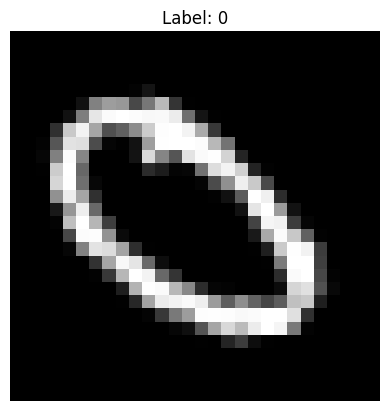

In [8]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))

print("Image shape:", images[0].shape)  
image = images[0].squeeze().cpu().numpy()  
print("Squeezed shape:", image.shape)  

# Plot
plt.imshow(image, cmap='gray')
plt.title(f"Label: {labels[0].item()}")
plt.axis('off')
plt.show()


## Experiment

In [4]:
# ----- Helper Functions -----
def init_model(name):
    if name == "big15_p4_cnn":
        return B15_P4CNN()
    if name == "chA_p4_cnn":
        return A_Ch_P4CNN()
    elif name == "spA_p4_cnn":
        return A_Sp_P4CNN()
    elif name == "big11_p4_cnn":
        return B11_P4CNN()
    elif name == "fA_p4_allcnn":
        return fA_P4AllCNNC()
    else:
        raise ValueError(f"Unknown model name: {name}")

def init_optimizer(model, lr, weight_decay):
    return optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)

def init_scheduler(optimizer, milestones):
    return optim.lr_scheduler.MultiStepLR(optimizer, milestones=[200, 250, 300], gamma=0.1)

# ----- Helper Classes -----
@dataclass
class HyperParams:
    lr: float
    epochs: int
    weight_decay: float
    momentum: float
    gamma: float
    milestones: List[int] = field(default_factory=list)

In [12]:
# ----- Configuration -----
num_iterations = 3
log_dir = "../logs"

model_hyperparameters = {
    "big15_p4_cnn":  HyperParams(lr=0.01, epochs=10, weight_decay=1e-3, momentum=0.9, milestones=[200, 250, 300], gamma=0.1),
    "chA_p4_cnn":  HyperParams(lr=0.01, epochs=10, weight_decay=1e-3, momentum=0.9, milestones=[200, 250, 300], gamma=0.1),
    "spA_p4_cnn": HyperParams(lr=0.01, epochs=10, weight_decay=1e-3, momentum=0.9, milestones=[200, 250, 300], gamma=0.1),
    "big11_p4_cnn":  HyperParams(lr=0.01, epochs=10, weight_decay=1e-3, momentum=0.9, milestones=[200, 250, 300], gamma=0.1),
    "fA_p4_allcnn": HyperParams(lr=0.01, epochs=10, weight_decay=1e-3, momentum=0.9, milestones=[200, 250, 300], gamma=0.1)
}
model_names = model_hyperparameters.keys()
accuracies = {name: [] for name in model_names}

In [13]:
# ----- Main Training Loop -----
for it in range(num_iterations):
    print(f"Iteration {it + 1}/{num_iterations}")

    for name in model_names:
        print(f"\n→ Training model: {name}")

        # 1. Grab hyperparams for this model
        hp = model_hyperparameters[name]

        # 2. Initialize model, criterion, optimizer, scheduler
        model = init_model(name)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(
            model.parameters(),
            lr=hp.lr,
            momentum=hp.momentum,
            weight_decay=hp.weight_decay
        )
        scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer,
            milestones=hp.milestones,
            gamma=hp.gamma
        )

        # 3. Wrap in our Trainer (single‐model)
        trainer = Trainer(
            models={name: model},
            optimizers=[optimizer],
            criterions=[criterion],
            schedulers=[scheduler],
            log_dir=f"{log_dir}/{name}"
        )

        # 4. Train & validate with the model‐specific epoch count
        trainer.train(
            num_epochs=hp.epochs,
            train_loader=train_loader,
            val_loader=val_loader,
        )

        # 5. Evaluate on test set and record accuracy
        test_acc = trainer.evaluate(test_loader=test_loader)[name]
        accuracies[name].append(test_acc)

Iteration 1/3

→ Training model: big15_p4_cnn
Using device: cuda
Current GPU: Tesla T4
Training model : big15_p4_cnn


Training Epochs: 100%|██████████| 10/10 [00:26<00:00,  2.69s/it, Train Acc=0.7866, Val Acc=0.7558, Train Loss=0.6438, Val Loss=0.7592]



→ Training model: chA_p4_cnn
Using device: cuda
Current GPU: Tesla T4
Training model : chA_p4_cnn


Training Epochs: 100%|██████████| 10/10 [01:33<00:00,  9.31s/it, Train Acc=0.9231, Val Acc=0.9550, Train Loss=0.2415, Val Loss=0.1443]



→ Training model: spA_p4_cnn
Using device: cuda
Current GPU: Tesla T4
Training model : spA_p4_cnn


Training Epochs: 100%|██████████| 10/10 [02:12<00:00, 13.22s/it, Train Acc=0.9331, Val Acc=0.9475, Train Loss=0.2117, Val Loss=0.1689]



→ Training model: big11_p4_cnn
Using device: cuda
Current GPU: Tesla T4
Training model : big11_p4_cnn


Training Epochs: 100%|██████████| 10/10 [00:17<00:00,  1.77s/it, Train Acc=0.9201, Val Acc=0.9492, Train Loss=0.2512, Val Loss=0.1607]



→ Training model: fA_p4_allcnn
Using device: cuda
Current GPU: Tesla T4
Training model : fA_p4_allcnn


Training Epochs: 100%|██████████| 10/10 [02:01<00:00, 12.16s/it, Train Acc=0.9625, Val Acc=0.9283, Train Loss=0.2245, Val Loss=0.3012]


Iteration 2/3

→ Training model: big15_p4_cnn
Using device: cuda
Current GPU: Tesla T4
Training model : big15_p4_cnn


Training Epochs: 100%|██████████| 10/10 [00:25<00:00,  2.52s/it, Train Acc=0.7370, Val Acc=0.3667, Train Loss=0.8096, Val Loss=2.4863]



→ Training model: chA_p4_cnn
Using device: cuda
Current GPU: Tesla T4
Training model : chA_p4_cnn


Training Epochs: 100%|██████████| 10/10 [01:32<00:00,  9.23s/it, Train Acc=0.9292, Val Acc=0.9617, Train Loss=0.2340, Val Loss=0.1233]



→ Training model: spA_p4_cnn
Using device: cuda
Current GPU: Tesla T4
Training model : spA_p4_cnn


Training Epochs: 100%|██████████| 10/10 [02:11<00:00, 13.13s/it, Train Acc=0.9323, Val Acc=0.9533, Train Loss=0.2153, Val Loss=0.1458]



→ Training model: big11_p4_cnn
Using device: cuda
Current GPU: Tesla T4
Training model : big11_p4_cnn


Training Epochs: 100%|██████████| 10/10 [00:17<00:00,  1.78s/it, Train Acc=0.9244, Val Acc=0.9575, Train Loss=0.2403, Val Loss=0.1539]



→ Training model: fA_p4_allcnn
Using device: cuda
Current GPU: Tesla T4
Training model : fA_p4_allcnn


Training Epochs: 100%|██████████| 10/10 [02:02<00:00, 12.22s/it, Train Acc=0.9652, Val Acc=0.9583, Train Loss=0.2108, Val Loss=0.2096]


Iteration 3/3

→ Training model: big15_p4_cnn
Using device: cuda
Current GPU: Tesla T4
Training model : big15_p4_cnn


Training Epochs: 100%|██████████| 10/10 [00:25<00:00,  2.55s/it, Train Acc=0.7190, Val Acc=0.4983, Train Loss=0.8299, Val Loss=1.6708]



→ Training model: chA_p4_cnn
Using device: cuda
Current GPU: Tesla T4
Training model : chA_p4_cnn


Training Epochs: 100%|██████████| 10/10 [01:31<00:00,  9.20s/it, Train Acc=0.9220, Val Acc=0.9517, Train Loss=0.2431, Val Loss=0.1486]



→ Training model: spA_p4_cnn
Using device: cuda
Current GPU: Tesla T4
Training model : spA_p4_cnn


Training Epochs: 100%|██████████| 10/10 [02:11<00:00, 13.14s/it, Train Acc=0.9310, Val Acc=0.9533, Train Loss=0.2258, Val Loss=0.1448]



→ Training model: big11_p4_cnn
Using device: cuda
Current GPU: Tesla T4
Training model : big11_p4_cnn


Training Epochs: 100%|██████████| 10/10 [00:17<00:00,  1.80s/it, Train Acc=0.9161, Val Acc=0.9583, Train Loss=0.2661, Val Loss=0.1314]



→ Training model: fA_p4_allcnn
Using device: cuda
Current GPU: Tesla T4
Training model : fA_p4_allcnn


Training Epochs: 100%|██████████| 10/10 [02:01<00:00, 12.18s/it, Train Acc=0.9671, Val Acc=0.9192, Train Loss=0.2074, Val Loss=0.2976]


In [14]:
# ----- Final Statistics -----
final_stats = {
    name: {
        "% Test error": (1 - float(np.mean(vals))) * 100,
        "% std": float(np.std(vals)) * 100,
        "Num Parameters": sum(p.numel() for p in init_model(name).parameters())
    }
    for name, vals in accuracies.items()
}

## Table generation

In [15]:
df = pd.DataFrame.from_dict(final_stats, orient='index')
df = df.round(2)
print("📊 Model Accuracy Summary in CIFAR10\n")
print(tabulate(df, headers="keys", tablefmt="fancy_grid"))

📊 Model Accuracy Summary in CIFAR10

╒══════════════╤════════════════╤═════════╤══════════════════╕
│              │   % Test error │   % std │   Num Parameters │
╞══════════════╪════════════════╪═════════╪══════════════════╡
│ big15_p4_cnn │          47.64 │   16.31 │  42710           │
├──────────────┼────────────────┼─────────┼──────────────────┤
│ chA_p4_cnn   │           5.41 │    0.52 │  45830           │
├──────────────┼────────────────┼─────────┼──────────────────┤
│ spA_p4_cnn   │           5.58 │    0.35 │  46310           │
├──────────────┼────────────────┼─────────┼──────────────────┤
│ big11_p4_cnn │           5.49 │    0.31 │  24610           │
├──────────────┼────────────────┼─────────┼──────────────────┤
│ fA_p4_allcnn │           6.2  │    1.36 │      1.40012e+06 │
╘══════════════╧════════════════╧═════════╧══════════════════╛
